In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 시드 고정 코드
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
# 데이터 로드 함수 정의 (데이터 전체 사용)
def load_data(db_path, year):
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql(f"SELECT * FROM '{year}'", conn)
    df = df.drop(columns=['저장시간']).select_dtypes(include=[np.number])
    df = df.interpolate(method='linear', limit_direction='both')  # 결측치 보간
    return df

In [ ]:
# 데이터셋 경로
db_paths = {
    "Iksan": "/content/drive/MyDrive/Tomato_db/Iksan.db",
    "Jeongeup": "/content/drive/MyDrive/Tomato_db/Jeongeup.db",
    "Sacheon_Kang": "/content/drive/MyDrive/Tomato_db/Sacheon_Kang.db",
    "Sacheon_Kim": "/content/drive/MyDrive/Tomato_db/Sacheon_Kim.db"
}

# 데이터 로드
data_sources = {
    "Iksan": {year: load_data(db_paths["Iksan"], year) for year in ['2018', '2019', '2020', '2021', '2022']},
    "Jeongeup": {year: load_data(db_paths["Jeongeup"], year) for year in ['2018', '2019', '2020', '2021', '2022']},
    "Sacheon_Kang": {year: load_data(db_paths["Sacheon_Kang"], year) for year in ['2018', '2019', '2020', '2021', '2022']},
    "Sacheon_Kim": {year: load_data(db_paths["Sacheon_Kim"], year) for year in ['2020', '2021', '2022']}
}

# 데이터 병합
train_data = pd.concat([
    data_sources["Iksan"]['2018'], data_sources["Iksan"]['2019'], data_sources["Iksan"]['2020'],
    data_sources["Jeongeup"]['2018'], data_sources["Jeongeup"]['2019'], data_sources["Jeongeup"]['2020'],
    data_sources["Sacheon_Kang"]['2018'], data_sources["Sacheon_Kang"]['2019'], data_sources["Sacheon_Kang"]['2020'],
    data_sources["Sacheon_Kim"]['2020']
], axis=0)

val_data = pd.concat([
    data_sources["Iksan"]['2021'], data_sources["Jeongeup"]['2021'], data_sources["Sacheon_Kang"]['2021'],
    data_sources["Sacheon_Kim"]['2021']
], axis=0)

test_data = pd.concat([
    data_sources["Iksan"]['2022'], data_sources["Jeongeup"]['2022'], data_sources["Sacheon_Kang"]['2022'],
    data_sources["Sacheon_Kim"]['2022']
], axis=0)


In [ ]:
config = {
    "sequence_length": 30,
    "batch_size": 1024,
    "hidden_size": 512,
    "num_layers": 1,
    "dropout_rate": 0,
    "learning_rate": 0.0001,
    "num_epochs": 100,
    "target_column": "내부온도",
    "feature_columns": ['내부온도', '외부온도', '풍향', '풍속', '일사량', '누적일사량', '감우'],
    "model_type": "LSTM"  # "LSTM", "GRU", "RNN" 중 하나를 선택
}

In [ ]:
# 데이터 전처리
def preprocess_data(df, scaler=None, fit_scaler=False):
    if fit_scaler:
        scaler = MinMaxScaler().fit(df[config["feature_columns"] + [config["target_column"]]])
    scaled = scaler.transform(df[config["feature_columns"] + [config["target_column"]]])

    x = np.array([scaled[i-config["sequence_length"]:i, :len(config["feature_columns"])]
                  for i in range(config["sequence_length"], len(scaled))])
    y = np.array([scaled[i, len(config["feature_columns"]):] for i in range(config["sequence_length"], len(scaled))])

    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), scaler

In [ ]:
# 스케일러 설정 및 데이터 전처리
scaler = MinMaxScaler()
scaler.fit(pd.concat([train_data, val_data, test_data])[config["feature_columns"] + [config["target_column"]]])

x_train, y_train, _ = preprocess_data(train_data, scaler, fit_scaler=False)
x_val, y_val, _ = preprocess_data(val_data, scaler, fit_scaler=False)
x_test, y_test, _ = preprocess_data(test_data, scaler, fit_scaler=False)

# DataLoader 생성
train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(TensorDataset(x_val, y_val), batch_size=config["batch_size"], shuffle=False)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size=config["batch_size"], shuffle=False)

In [ ]:
# RNN 모델 정의
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate, nonlinearity='tanh')
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 12),
            nn.ReLU(),
            nn.Linear(12, output_size)
        )

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 12),
            nn.ReLU(),
            nn.Linear(12, output_size)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# GRU 모델 정의
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_rate):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, 12),
            nn.ReLU(),
            nn.Linear(12, output_size)
        )

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

# 모델 선택 함수
def select_model(model_type, input_size, hidden_size, output_size, num_layers, dropout_rate):
    if model_type == "LSTM":
        return LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_rate)
    elif model_type == "GRU":
        return GRUModel(input_size, hidden_size, output_size, num_layers, dropout_rate)
    elif model_type == "RNN":
        return RNNModel(input_size, hidden_size, output_size, num_layers, dropout_rate)
    else:
        raise ValueError("Invalid model type. Choose from 'LSTM', 'GRU', or 'RNN'.")

Epoch 1, Training Loss: 0.0003091, Validation Loss: 0.0000218


Epoch 2, Training Loss: 0.0000176, Validation Loss: 0.0000125


Epoch 3, Training Loss: 0.0000094, Validation Loss: 0.0000070


Epoch 4, Training Loss: 0.0000068, Validation Loss: 0.0000051


Epoch 5, Training Loss: 0.0000055, Validation Loss: 0.0000076


Epoch 6, Training Loss: 0.0000049, Validation Loss: 0.0000076


Epoch 7, Training Loss: 0.0000045, Validation Loss: 0.0000037


Epoch 8, Training Loss: 0.0000042, Validation Loss: 0.0000045


Epoch 9, Training Loss: 0.0000040, Validation Loss: 0.0000038


Epoch 10, Training Loss: 0.0000039, Validation Loss: 0.0000033


Epoch 11, Training Loss: 0.0000039, Validation Loss: 0.0000066


Epoch 12, Training Loss: 0.0000038, Validation Loss: 0.0000036


Epoch 13, Training Loss: 0.0000038, Validation Loss: 0.0000042


Epoch 14, Training Loss: 0.0000037, Validation Loss: 0.0000034


Epoch 15, Training Loss: 0.0000037, Validation Loss: 0.0000034


Epoch 16, Training Loss: 0.0000037, Validation Loss: 0.0000033


Epoch 17, Training Loss: 0.0000037, Validation Loss: 0.0000033


Epoch 18, Training Loss: 0.0000037, Validation Loss: 0.0000032


Epoch 19, Training Loss: 0.0000037, Validation Loss: 0.0000037


Epoch 20, Training Loss: 0.0000036, Validation Loss: 0.0000033


Epoch 21, Training Loss: 0.0000036, Validation Loss: 0.0000032


Epoch 22, Training Loss: 0.0000036, Validation Loss: 0.0000032


Epoch 23, Training Loss: 0.0000036, Validation Loss: 0.0000033


Epoch 24, Training Loss: 0.0000036, Validation Loss: 0.0000034


Epoch 25, Training Loss: 0.0000036, Validation Loss: 0.0000033


Epoch 26, Training Loss: 0.0000036, Validation Loss: 0.0000032


Epoch 27, Training Loss: 0.0000036, Validation Loss: 0.0000032


Epoch 28, Training Loss: 0.0000035, Validation Loss: 0.0000032


Epoch 29, Training Loss: 0.0000035, Validation Loss: 0.0000032


Epoch 30, Training Loss: 0.0000035, Validation Loss: 0.0000033


Epoch 31, Training Loss: 0.0000035, Validation Loss: 0.0000037


Epoch 32, Training Loss: 0.0000035, Validation Loss: 0.0000032


Epoch 33, Training Loss: 0.0000035, Validation Loss: 0.0000033


Epoch 34, Training Loss: 0.0000035, Validation Loss: 0.0000031


Epoch 35, Training Loss: 0.0000035, Validation Loss: 0.0000032


Epoch 36, Training Loss: 0.0000035, Validation Loss: 0.0000034


Epoch 37, Training Loss: 0.0000035, Validation Loss: 0.0000032


Epoch 38, Training Loss: 0.0000035, Validation Loss: 0.0000035


Epoch 39, Training Loss: 0.0000035, Validation Loss: 0.0000033


Epoch 40, Training Loss: 0.0000035, Validation Loss: 0.0000031


Epoch 41, Training Loss: 0.0000035, Validation Loss: 0.0000035


Epoch 42, Training Loss: 0.0000034, Validation Loss: 0.0000032


Epoch 43, Training Loss: 0.0000035, Validation Loss: 0.0000038


Epoch 44, Training Loss: 0.0000034, Validation Loss: 0.0000032


Epoch 45, Training Loss: 0.0000034, Validation Loss: 0.0000033


Epoch 46, Training Loss: 0.0000034, Validation Loss: 0.0000033


Epoch 47, Training Loss: 0.0000034, Validation Loss: 0.0000032


Epoch 48, Training Loss: 0.0000034, Validation Loss: 0.0000033


Epoch 49, Training Loss: 0.0000034, Validation Loss: 0.0000031


Epoch 50, Training Loss: 0.0000034, Validation Loss: 0.0000031


Epoch 51, Training Loss: 0.0000034, Validation Loss: 0.0000031


Epoch 52, Training Loss: 0.0000034, Validation Loss: 0.0000032


Epoch 53, Training Loss: 0.0000034, Validation Loss: 0.0000033


Epoch 54, Training Loss: 0.0000034, Validation Loss: 0.0000031


Epoch 55, Training Loss: 0.0000034, Validation Loss: 0.0000031


Epoch 56, Training Loss: 0.0000034, Validation Loss: 0.0000031


Epoch 57, Training Loss: 0.0000034, Validation Loss: 0.0000035


Epoch 58, Training Loss: 0.0000034, Validation Loss: 0.0000035


Epoch 59, Training Loss: 0.0000034, Validation Loss: 0.0000031


Epoch 60, Training Loss: 0.0000034, Validation Loss: 0.0000032


Epoch 61, Training Loss: 0.0000034, Validation Loss: 0.0000031


Epoch 62, Training Loss: 0.0000034, Validation Loss: 0.0000032


Epoch 63, Training Loss: 0.0000034, Validation Loss: 0.0000031


Epoch 64, Training Loss: 0.0000033, Validation Loss: 0.0000032


Epoch 65, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 66, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 67, Training Loss: 0.0000034, Validation Loss: 0.0000033


Epoch 68, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 69, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 70, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 71, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 72, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 73, Training Loss: 0.0000033, Validation Loss: 0.0000032


Epoch 74, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 75, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 76, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 77, Training Loss: 0.0000033, Validation Loss: 0.0000033


Epoch 78, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 79, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 80, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 81, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 82, Training Loss: 0.0000033, Validation Loss: 0.0000032


Epoch 83, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 84, Training Loss: 0.0000033, Validation Loss: 0.0000032


Epoch 85, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 86, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 87, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 88, Training Loss: 0.0000033, Validation Loss: 0.0000032


Epoch 89, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 90, Training Loss: 0.0000033, Validation Loss: 0.0000033


Epoch 91, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 92, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 93, Training Loss: 0.0000033, Validation Loss: 0.0000032


Epoch 94, Training Loss: 0.0000033, Validation Loss: 0.0000032


Epoch 95, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 96, Training Loss: 0.0000033, Validation Loss: 0.0000034


Epoch 97, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 98, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 99, Training Loss: 0.0000033, Validation Loss: 0.0000031


Epoch 100, Training Loss: 0.0000033, Validation Loss: 0.0000030
Best model saved with Validation Loss: 0.0000030 at /content/drive/MyDrive/best_model.pth


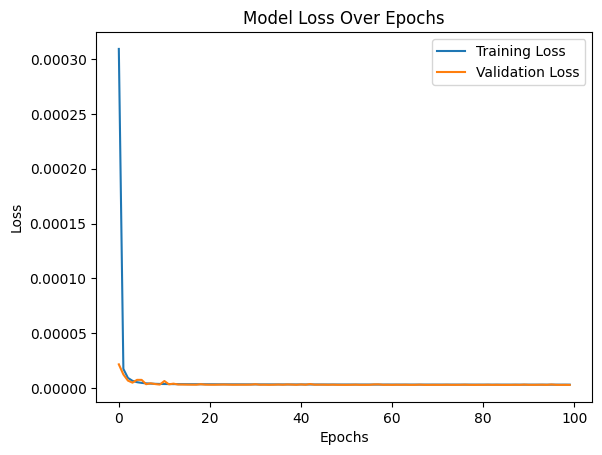

In [ ]:
# 모델 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = select_model(
    model_type=config["model_type"],
    input_size=x_train.shape[2],
    hidden_size=config["hidden_size"],
    output_size=y_train.shape[1],
    num_layers=config["num_layers"],
    dropout_rate=config["dropout_rate"]
).to(device)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=config["learning_rate"])

# 최적 모델 저장 변수 초기화
best_model_state = None
min_val_loss = float("inf")


# 학습 루프
train_losses, val_losses = [], []

for epoch in range(config["num_epochs"]):
    model.train()
    running_loss = 0.0

    # tqdm을 사용하여 진행 상황 표시
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{config['num_epochs']}", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        loss = criterion(model(inputs), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # 검증 손실 계산
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            loss = criterion(model(inputs), targets)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}, Training Loss: {train_losses[-1]:.7f}, Validation Loss: {val_loss:.7f}")

    # 최적 모델 상태 저장
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        best_model_state = model.state_dict()  # 모델 상태 저장

# 학습 종료 후 최적 모델 저장
if best_model_state is not None:
    best_model_path = "/content/drive/MyDrive/best_model.pth"
    torch.save(best_model_state, best_model_path)
    print(f"Best model saved with Validation Loss: {min_val_loss:.7f} at {best_model_path}")

# 학습 손실 그래프
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


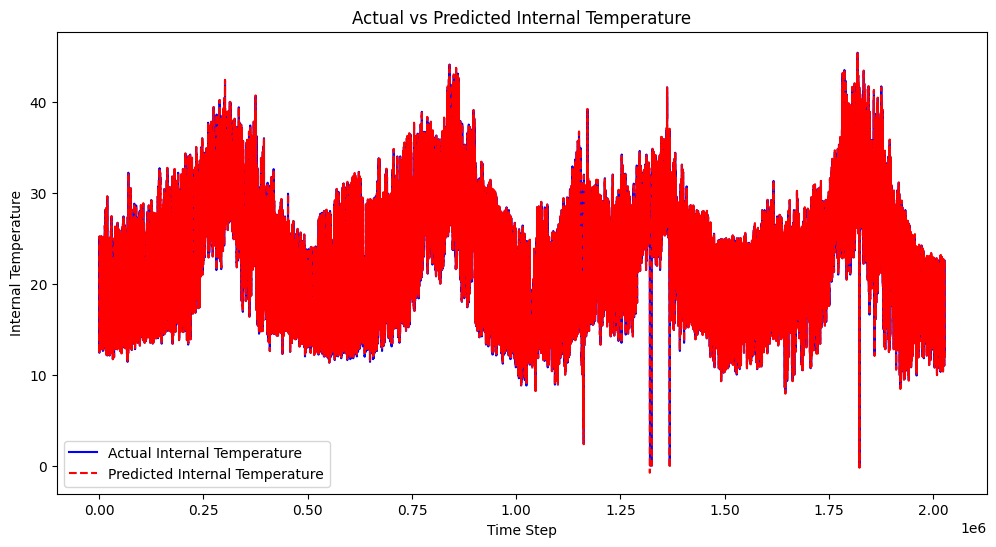

In [ ]:
# 테스트 데이터 예측 및 실제 값 비교
model.load_state_dict(torch.load(best_model_path, weights_only=True), strict=True)
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())

# 리스트를 배열로 변환
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# 원래 스케일로 복원 (내부 온도 값만)
predictions = scaler.inverse_transform(np.hstack((np.zeros((predictions.shape[0], len(config["feature_columns"]))), predictions)))[:, -1]
actuals = scaler.inverse_transform(np.hstack((np.zeros((actuals.shape[0], len(config["feature_columns"]))), actuals)))[:, -1]

# 예측값과 실제값 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Internal Temperature", color="blue")
plt.plot(predictions, label="Predicted Internal Temperature", color="red", linestyle="--")
plt.title("Actual vs Predicted Internal Temperature")
plt.xlabel("Time Step")
plt.ylabel("Internal Temperature")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# 역정규화 함수
def inverse_transform(scaler, data, columns):
    full_data = np.zeros((data.shape[0], len(config["feature_columns"]) + 1))  # feature_columns와 target_column을 포함한 크기
    full_data[:, -1] = data.squeeze()  # target column에만 예측값 할당
    inversed = scaler.inverse_transform(full_data)  # 역정규화
    return inversed[:, -1]  # target column만 반환

# 2022년도 테스트 데이터 예측 및 역정규화
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        output = model(inputs).cpu().numpy()
        predictions.append(output)
        actuals.append(targets.cpu().numpy())

# 예측값과 실제값 배열로 변환
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

# 예측값과 실제값 역정규화
predictions_inverse = inverse_transform(scaler, predictions, config["target_column"])
actuals_inverse = inverse_transform(scaler, actuals, config["target_column"])

# RMSE 및 R² 계산
rmse = np.sqrt(mean_squared_error(actuals_inverse, predictions_inverse))
r2 = r2_score(actuals_inverse, predictions_inverse)

print(f"2022년 데이터에 대한 역정규화된 RMSE: {rmse:.4f}")
print(f"2022년 데이터에 대한 역정규화된 R^2: {r2:.4f}")


2022년 데이터에 대한 역정규화된 RMSE: 0.1248
2022년 데이터에 대한 역정규화된 R^2: 0.9996
